# Installing necessary packages

In [ ]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn pillow graphviz pydot pandas
!pip install opencv-python-headless
!pip install mlxtend  
!pip install lime shap


# Importing Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
import tensorflow.keras.backend as K
import tensorflow as tf
import shap
import lime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model, Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries

2024-09-04 10:08:30.731781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 10:08:30.743810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 10:08:30.747458: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 10:08:30.757503: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Loading & Preprocessing

### Loading Data From directory
### Data Augmentation & Preprocessing
### Data Generators (ImageDataGenerator)

In [2]:
# Define the data paths
train_dir = 'Dissertation/chest_xray/train/'
test_dir = 'Dissertation/chest_xray/test/'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=False)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Balancing Class weights

In [3]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(train_generator.classes), 
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

print(f'Computed class weights: {class_weights}')


Computed class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


# Deep learning Model Implementation

# 1. VGG-16

## Model Building
### Load the base pre-trained VGG-16 model
### Fine-tune model through freezing and unfreezing layers
### Define model structure
### confirming model structure as per input shape
### Compile the model as per the optimizer, categorical cross-entropy and accuracy as metric
### Define necessary callbacks for optimization during training

In [5]:
# Loading the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add new layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Flattening the features
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # categorical classification
])

# Ensuring the model structure is correct
try:
    model.build(input_shape=(None, 224, 224, 3))  
    model.summary()
except ValueError as e:
    print(f"Model summary error: {e}")

# Compiling the model after unfreezing the layers
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


2024-09-04 10:08:41.367770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43622 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 7,343,106 (28.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Training the fine tuned Model

In [6]:
# Training the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weights,  
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725444528.530167     884 service.cc:146] XLA service 0x78e05400f8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725444528.530250     884 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-09-04 10:08:48.589138: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 10:08:48.779698: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-04 10:08:50

  1/163 ━━━━━━━━━━━━━━━━━━━━ 29:00 11s/step - accuracy: 0.3750 - loss: 0.6971

I0000 00:00:1725444535.699346     884 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 326ms/step - accuracy: 0.6694 - loss: 0.5491 - val_accuracy: 0.8622 - val_loss: 0.3383 - learning_rate: 1.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 304ms/step - accuracy: 0.9400 - loss: 0.1482 - val_accuracy: 0.9071 - val_loss: 0.2400 - learning_rate: 1.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 291ms/step - accuracy: 0.9573 - loss: 0.1092 - val_accuracy: 0.9135 - val_loss: 0.2578 - learning_rate: 1.0000e-05
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.9623 - loss: 0.0970 - val_accuracy: 0.9119 - val_loss: 0.2847 - learning_rate: 1.0000e-05
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.9742 - loss: 0.0661 - val_accuracy: 0.9167 - val_loss: 0.2547 - learning_rate: 1.0000e-05


# Model Performance & Evaluation
### Loading the best VGG-16 model and conducting evaluation based on Test set

In [8]:
# Load the best model
model.load_weights('best_vgg16_model.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8973 - loss: 0.2797
Test accuracy: 90.71%


### Plotting training vs validation (Loss/Accuracy)
### Creating confusion matrix on positive and negative prediction rates
### Classification report

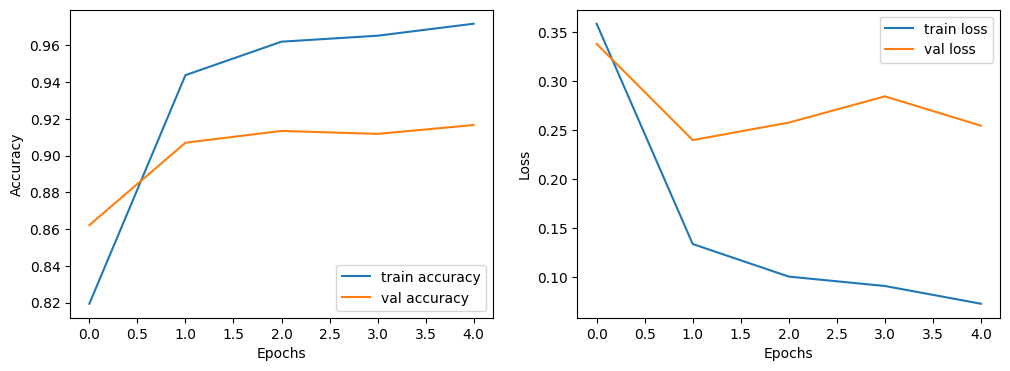

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
Confusion Matrix


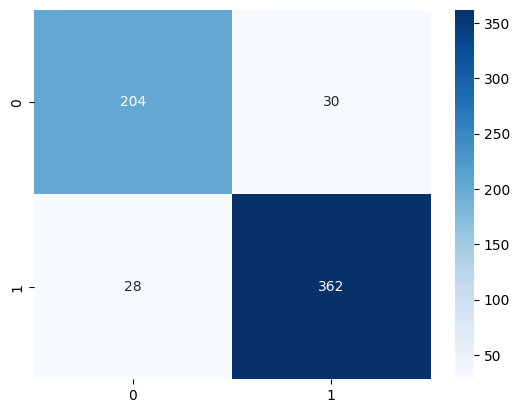

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.88      0.87      0.88       234
   PNEUMONIA       0.92      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



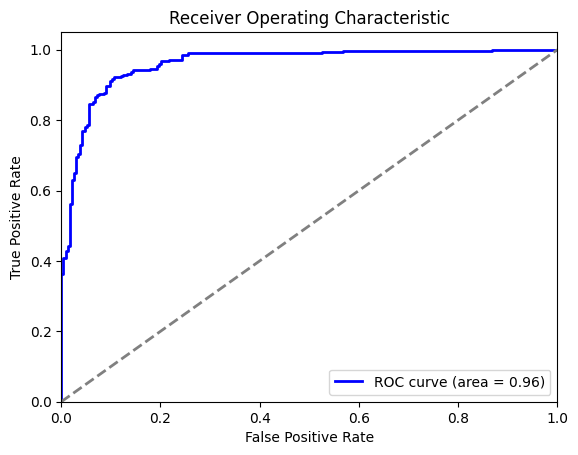

In [10]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)  # Compare class indices
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

# Classification Report
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# ROC AUC Curve
fpr, tpr, _ = roc_curve(validation_generator.classes, Y_pred[:, 1])  # Use probabilities for the positive class
roc_auc = roc_auc_score(validation_generator.classes, Y_pred[:, 1])

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 2. Densenet121

## Model Building
### Load the base pre-trained DenseNet121 model
### Build classification model by defining model structure
### Fine-tune the model
### Compile the model as per the optimizer, categorical cross-entropy and accuracy as metric
### Define necessary callbacks for optimization during training

In [11]:
from tensorflow.keras.applications.densenet import DenseNet121
# Loading the DenseNet121 model without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Building the classification model on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(256, kernel_regularizer='l2', kernel_initializer='he_normal', activation='relu')(x)
x = Dropout(rate=0.5)(x)
preds = Dense(2, activation='softmax')(x)  # binary classification output

# defining the full model
model = Model(inputs=base_model.input, outputs=preds)

# Freeze the initial layers and unfreeze next ones
for layer in model.layers[:313]:
    layer.trainable = False
for layer in model.layers[313:]:
    layer.trainable = True

# Compiling the model
opt = Adam(learning_rate=0.001, decay=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()

# Callbacks for training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint('densenet_weights.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 2,423,042 (9.24 MB)

 Non-trainable params: 4,877,376 (18.61 MB)

## Model Training

In [12]:
# Model fitting
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[lr_reduce, checkpoint, early_stopping],
    class_weight=class_weights, 
    epochs=5
)

Epoch 1/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8895 - loss: 3.2450

2024-09-04 10:18:11.741748: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314', 140 bytes spill stores, 140 bytes spill loads



163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 384ms/step - accuracy: 0.8900 - loss: 3.2305 - val_accuracy: 0.9071 - val_loss: 1.0941 - learning_rate: 0.0010
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - accuracy: 0.9623 - loss: 0.6922 - val_accuracy: 0.9279 - val_loss: 0.5705 - learning_rate: 0.0010
Epoch 3/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9792 - loss: 0.2887
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 296ms/step - accuracy: 0.9792 - loss: 0.2882 - val_accuracy: 0.8590 - val_loss: 0.7749 - learning_rate: 0.0010
Epoch 4/5
161/163 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9861 - loss: 0.1571
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.9861 - loss: 0.1569 - val_accuracy: 0.8910 - val_loss: 0.5718 - learning_rate: 2.0000e-04
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - accuracy: 0.9857 - loss: 0

# Model Performance & Evaluation

### Plotting Training vs Validation/ Test (Accuracy/Loss)

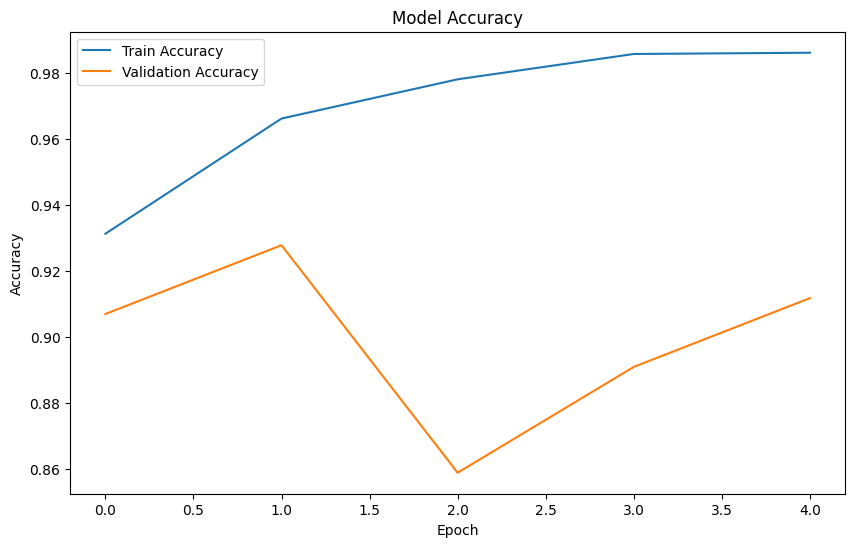

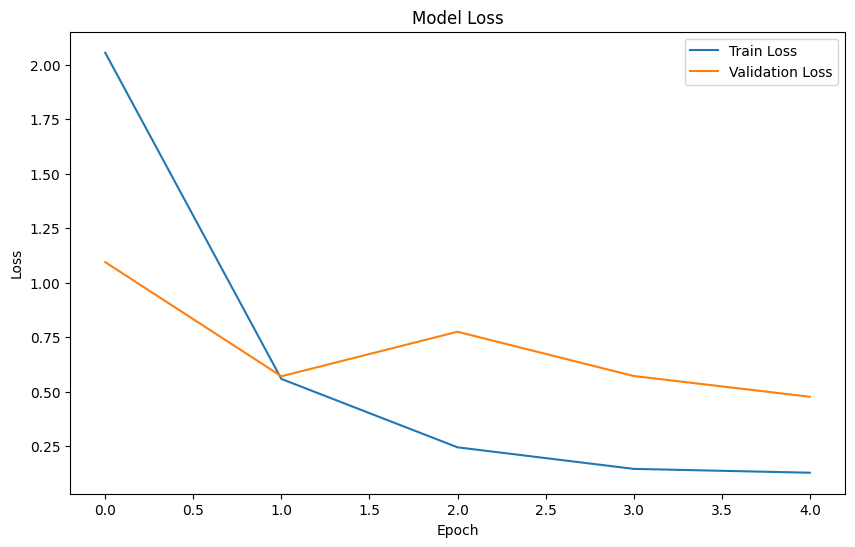

In [13]:
# Plot accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Classification Report
## Confusion matrix based on correct prediction and labelling on test data
## ROC-AUC curve
### After Creating test data frame for classification test
 

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step


<Figure size 640x480 with 0 Axes>

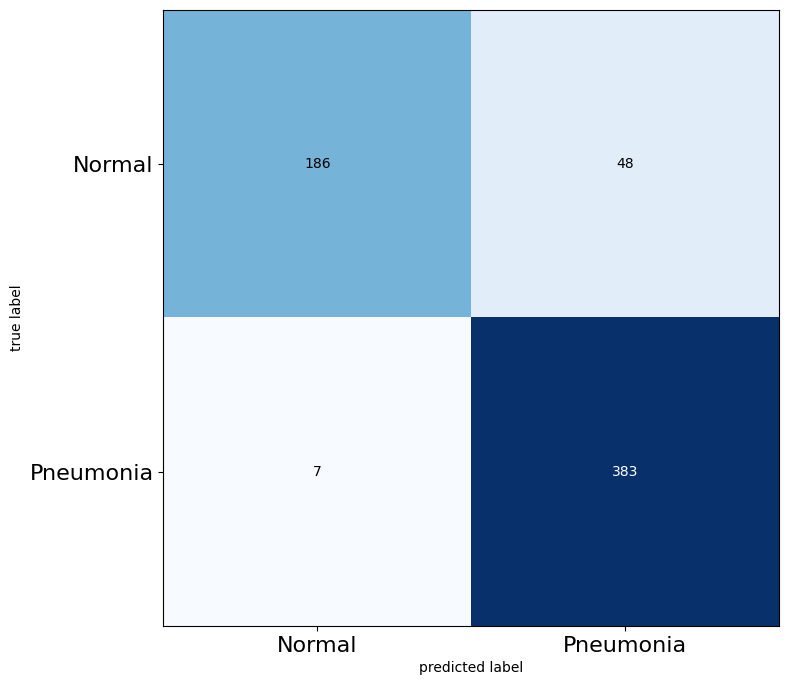

              precision    recall  f1-score   support

      Normal       0.96      0.79      0.87       234
   Pneumonia       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


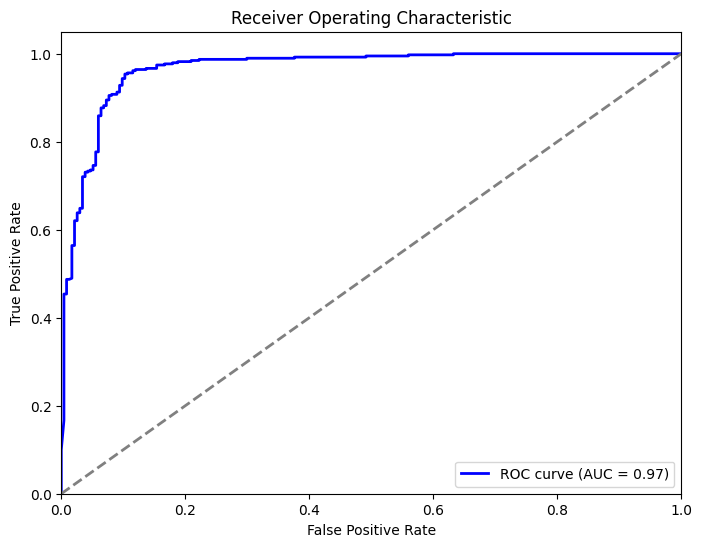

In [14]:
# Loading test images and labels
test_path = Path('Dissertation/chest_xray/test/')
normal_cases_dir = test_path / 'NORMAL'
pneumonia_cases_dir = test_path / 'PNEUMONIA'

# Create a DataFrame with test data
normal_cases = list(normal_cases_dir.glob('*.jpeg'))
pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))

test_data = [(img, 0) for img in normal_cases] + [(img, 1) for img in pneumonia_cases]
test_data = pd.DataFrame(test_data, columns=['image', 'label']).sample(frac=1.).reset_index(drop=True)

# Preprocess test data
def proc_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x_img = image.img_to_array(img)
    x_img = np.expand_dims(x_img, axis=0)
    return preprocess_input(x_img)

x_test = np.zeros((len(test_data), 224, 224, 3))
for i, img_path in enumerate(test_data['image']):
    x_test[i] = proc_img(str(img_path))

y_test_true = np.asarray(test_data['label'])
y_test_pred = np.argmax(model.predict(x_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# Classification report
print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'Pneumonia']))

# ROC-AUC Curve
y_test_pred_prob = model.predict(x_test)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(y_test_true, y_test_pred_prob)
roc_auc = roc_auc_score(y_test_true, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. MobileNet

## Model Building
### Load the base pre-trained MobileNet model
### Build classification model by defining model structure
### Fine-tune the model
### Compile the model as per the optimizer, categorical cross-entropy and accuracy as metric
### Define necessary callbacks for optimization during training

In [15]:
# Loading the MobileNet model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False)

# Building the classification model on top of MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(256, kernel_regularizer='l2', kernel_initializer='he_normal', activation='relu')(x)
x = Dropout(rate=0.5)(x)
preds = Dense(2, activation='softmax')(x)  # Output layer for binary classification

# Defining the full model
model = Model(inputs=base_model.input, outputs=preds)

# Freeze the initial layers and unfreeze next ones
for layer in model.layers[:53]:
    layer.trainable = False
for layer in model.layers[53:]:
    layer.trainable = True

# Compiling the model
# opt = Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, decay=0.0001, amsgrad=False)
opt = Adam(learning_rate=0.001, decay=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Displaying the model summary
model.summary()

/tmp/ipykernel_338/2222639910.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 2,664,194 (10.16 MB)

 Non-trainable params: 827,584 (3.16 MB)

## Training the model

In [16]:
# # Training the model
# step_size_train = train_generator.n // train_generator.batch_size
# step_size_val = validation_generator.n // validation_generator.batch_size
# Callbacks for training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint('weights.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#model fitting
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[lr_reduce, checkpoint,early_stopping],
    class_weight = class_weights,
    epochs=5
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 315ms/step - accuracy: 0.8891 - loss: 4.0494 - val_accuracy: 0.8173 - val_loss: 1.8227 - learning_rate: 0.0010
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accuracy: 0.9696 - loss: 0.9683 - val_accuracy: 0.9247 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.9832 - loss: 0.3260 - val_accuracy: 0.9343 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 290ms/step - accuracy: 0.9810 - loss: 0.1441 - val_accuracy: 0.9343 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9871 - loss: 0.0785
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 288ms/step - accuracy: 0.9871 - loss: 0.0785 - val_accuracy: 0.8926 - val_loss: 0.5304 - learning_rate: 0.0010


# Model Performance & Evaluation

### Plotting Training vs Validation/ Test (Accuracy/Loss)

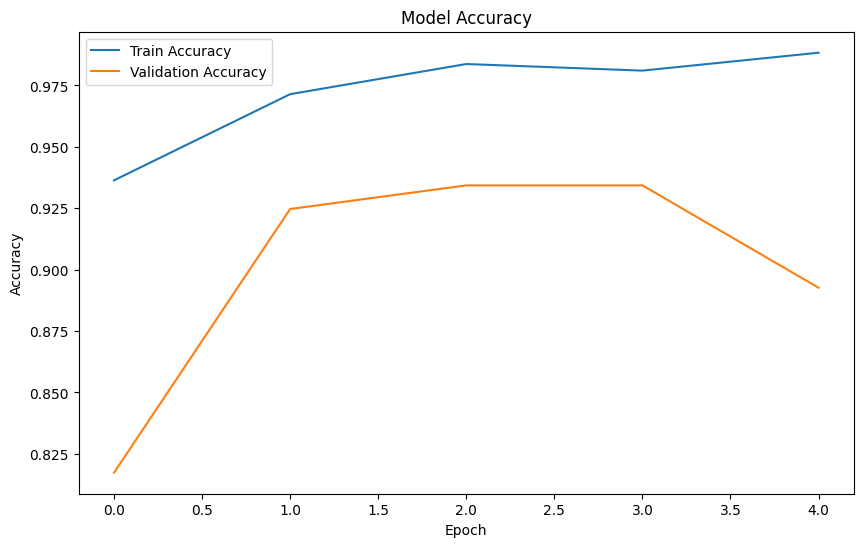

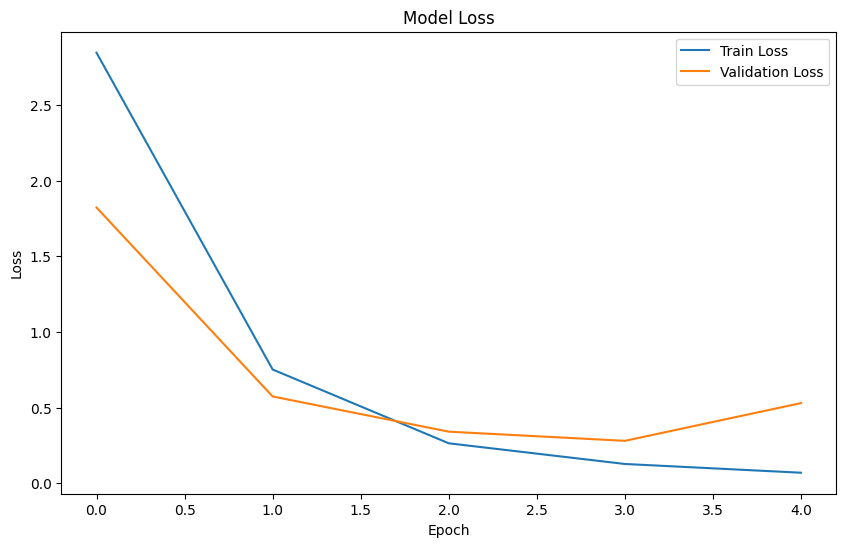

In [17]:
# Plot accuracy and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


## Classification Report
## Confusion matrix based on correct prediction and labelling on test data
### After Creating test data frame for classification test
 

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


<Figure size 640x480 with 0 Axes>

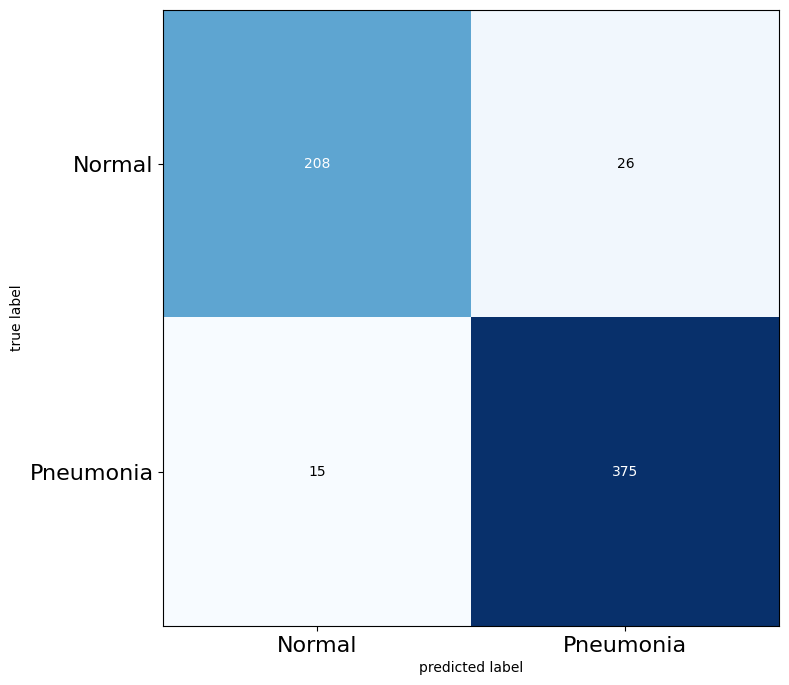

              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91       234
   Pneumonia       0.94      0.96      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



In [18]:
from tensorflow.keras.preprocessing import image

# Loading test images and labels
test_path = Path('Dissertation/chest_xray/test/')
normal_cases_dir = test_path / 'NORMAL'
pneumonia_cases_dir = test_path / 'PNEUMONIA'

# Creating a DataFrame with test data
normal_cases = list(normal_cases_dir.glob('*.jpeg'))
pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))

test_data = [(img, 0) for img in normal_cases] + [(img, 1) for img in pneumonia_cases]
test_data = pd.DataFrame(test_data, columns=['image', 'label']).sample(frac=1.).reset_index(drop=True)

# Preprocessing test data
def proc_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x_img = image.img_to_array(img)
    x_img = np.expand_dims(x_img, axis=0)
    return preprocess_input(x_img)

x_test = np.zeros((len(test_data), 224, 224, 3))
for i, img_path in enumerate(test_data['image']):
    x_test[i] = proc_img(str(img_path))

y_test_true = np.asarray(test_data['label'])
y_test_pred = np.argmax(model.predict(x_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# Classification report
print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'Pneumonia']))


## ROC-AUC curve

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


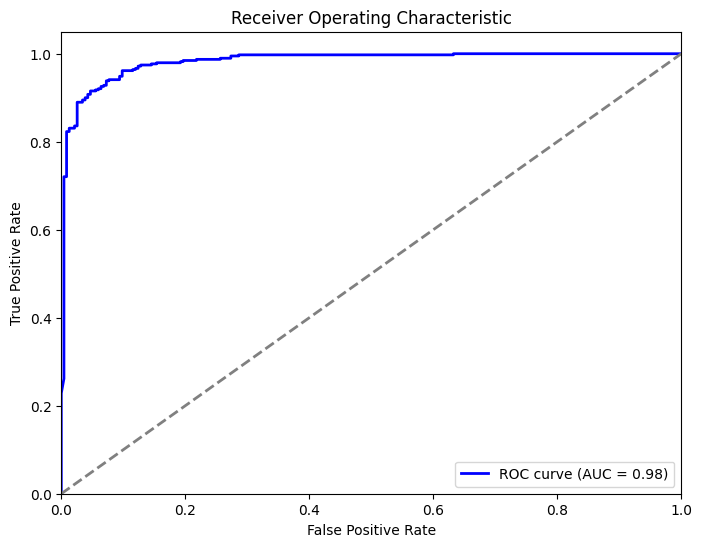

In [19]:
# ROC-AUC Curve
y_test_pred_prob = model.predict(x_test)[:, 1]  # Probability of the positive class
fpr, tpr, thresholds = roc_curve(y_test_true, y_test_pred_prob)
roc_auc = roc_auc_score(y_test_true, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# XAI Implementation

# 1. Grad-CAM

### Generating a Grad-CAM heatmap for a given image and convolutional layer within the model.
#### we take Preprocessed input image, convolutional layer inside the model, target label (class index), specific model (MobileNet ) for specification and generate a heatmap showing the regions important for the prediction.

W0000 00:00:1725446004.352924     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.369028     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.369287     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.369485     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.369742     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.369936     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.370173     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.370436     338 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725446004.370639     338 gp

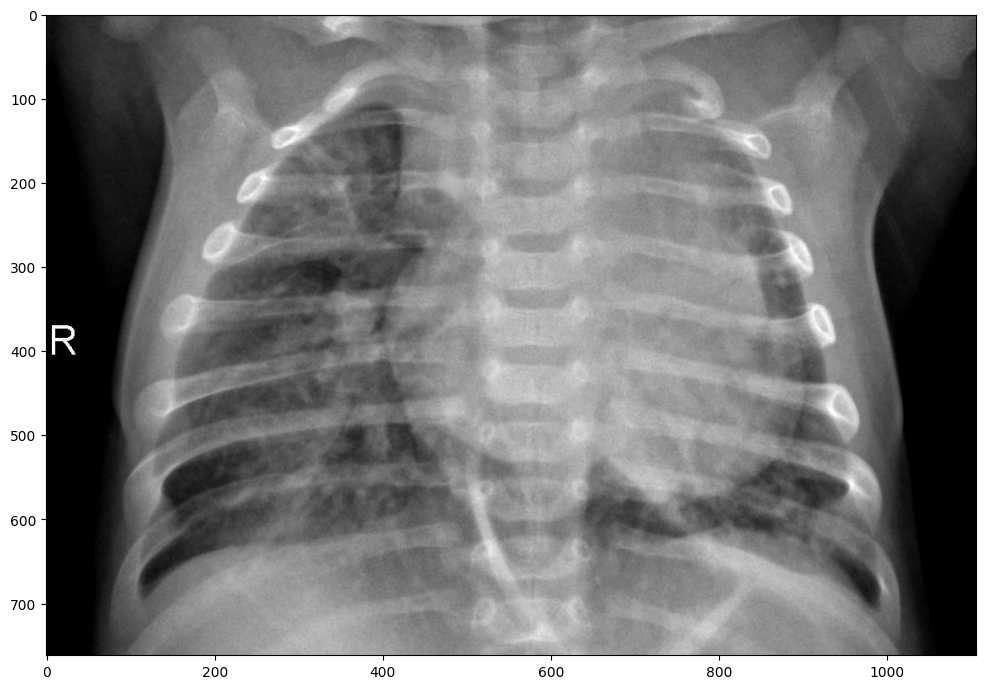

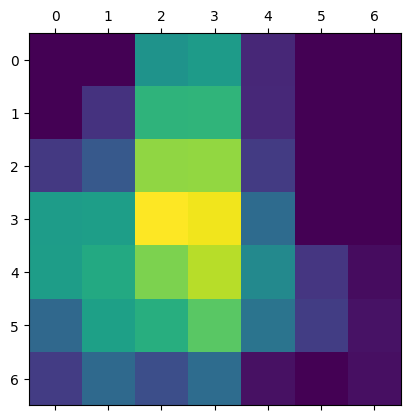

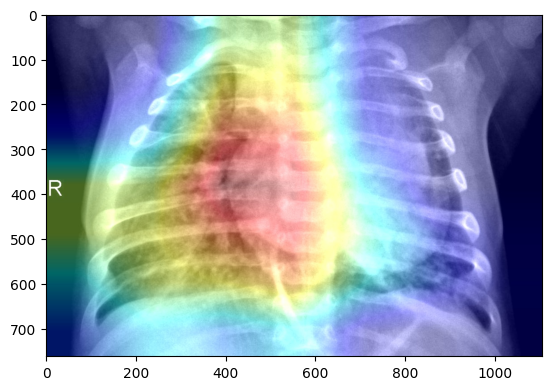

In [20]:
import tensorflow as tf

def xray_CAM(x_img, block, label): 
    # GradientTape for recording the operations for automatic differentiation
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(block).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x_img)
        loss = predictions[:, label]

    # calculating the gradient loss in reference with the output feature map of the conv layer
    grads = tape.gradient(loss, conv_outputs)

    # Pooling the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighing the output feature map with the gradients
    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Creating heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap

def show_on_xray(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./xray_cam.jpg', superimposed_img)
    img_samp = cv2.cvtColor(cv2.imread('./xray_cam.jpg'), cv2.COLOR_BGR2RGB)
    plt.imshow(img_samp)
    plt.show()

img_path = 'Dissertation/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
x_img = proc_img(img_path)
heatmap = xray_CAM(x_img, 'conv_pw_13', 1)  # MobileNet's last block
# Plot Grad-CAM heatmap
plt.figure(figsize=(12, 10))
plt.imshow(cv2.imread(img_path))

plt.matshow(heatmap)
plt.show()

# Show heatmap on X-ray image
show_on_xray(img_path, heatmap)


In [ ]:
# img_path = 'Dissertation/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
# x_img = proc_img(img_path)
# heatmap = xray_CAM(x_img, 'conv_pw_13', 1)  # MobileNet's last block
# # Plot Grad-CAM heatmap
# plt.figure(figsize=(12, 10))
# plt.imshow(cv2.imread(img_path))

# plt.matshow(heatmap)
# plt.show()

# # Show heatmap on X-ray image
# show_on_xray(img_path, heatmap)

# 2. LIME

## Generating LIME explanations through the MobileNet predictions.
### Load and preprocess the image data from test set and predict using the best saved MobileNet model and visualize LIME explanation super-imposed on the test image data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
Predicted class: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

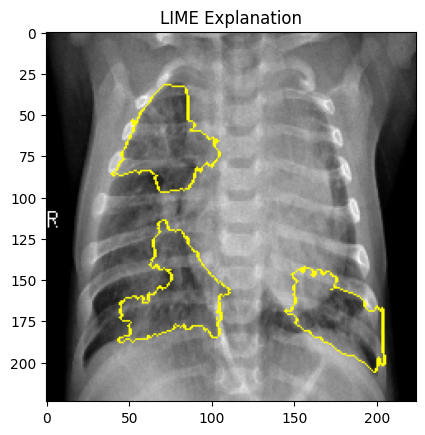

In [21]:
# Loading and preprocessing a test image for LIME explanation
img_path = str(list(pneumonia_cases_dir.glob('*.jpeg'))[0])  # Take the first pneumonia image for LIME explanation
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)  # Convert image to array
img_array_expanded = np.expand_dims(img_array, axis=0)  # Expand dimensions to fit model input
img_array_preprocessed = preprocess_input(img_array_expanded)  # Preprocess for MobileNet

# Predicting the image using the model
pred = model.predict(img_array_preprocessed)
print(f'Predicted class: {np.argmax(pred)}')

# LIME Explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_array.astype('double'),  # Using original image array
                                         model.predict,
                                         top_labels=2,
                                         hide_color=0,
                                         num_samples=1000)

# Visualizing LIME explanation
temp, mask = explanation.get_image_and_mask(np.argmax(pred), positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()

# 3. Saliency Maps

## Generating Saliency Maps through the MobileNet predictions .
### Load and preprocess the image data from test set and predict using the best saved MobileNet model and visualize LIME explanation super-imposed on the test image data
### displays a smooth saliency map using the SmoothGrad technique with refinement

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


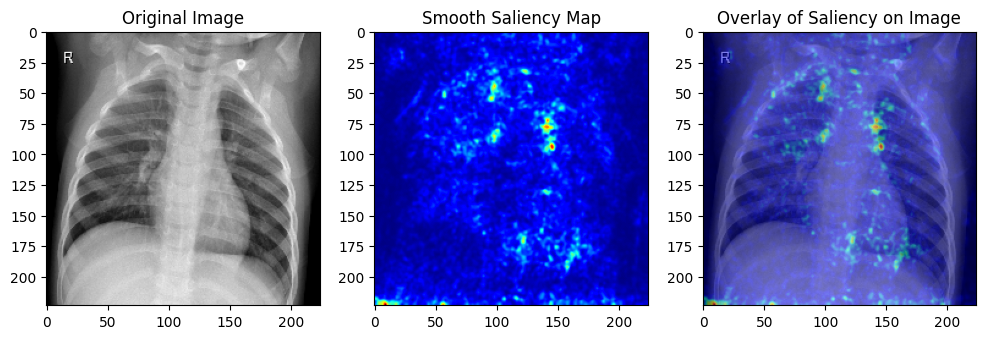

In [22]:

def generate_smoothgrad_saliency_map(img_path, model, num_samples=100, noise_level=0.1):
    
    # Loading the original image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # class prediction
    predictions = model.predict(x)
    predicted_class = np.argmax(predictions)

    # Initializing the saliency map
    smooth_grad = np.zeros_like(x)

    for i in range(num_samples):
        # Adding noise to the image through multiplying by noise level
        noisy_img = x + noise_level * np.random.normal(size=x.shape)
        noisy_img = np.clip(noisy_img, -1, 1)  # Ensure pixel values remain valid
        
        # Computing the gradient for the noisy image
        with tf.GradientTape() as tape:
            input_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
            tape.watch(input_img)
            preds = model(input_img)
            loss = preds[:, predicted_class]

        # Getting the gradient loss 
        grads = tape.gradient(loss, input_img)

        # Accumulating the gradients
        smooth_grad += grads.numpy()

    # Averaging the gradients across the samples
    smooth_grad /= num_samples

    # Getting maximum magnitude of the gradients across the color channels
    saliency = np.max(np.abs(smooth_grad), axis=-1)[0]

    # Normalizing the saliency map with enhanced contrast
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-10)  # small constant to avoid division by zero
    saliency = np.power(saliency, 1.5)  # Increasing contrast by squaring saliency values

    # Applying Gaussian blur to reduce noise 
    saliency = cv2.GaussianBlur(saliency, (5, 5), 0)  # Increasing kernel size slightly for finer balance and smoother saliency

    # Converting original image to grayscale for overlay
    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img_gray = cv2.resize(img_gray, (224, 224))

    # Overlaying the saliency map on the original image for better visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency, cmap='jet')
    plt.title('Smooth Saliency Map')

    plt.subplot(1, 3, 3)
    plt.imshow(img_gray, cmap='gray')
    plt.imshow(saliency, cmap='jet', alpha=0.5)  # Overlaying saliency map on grayscale original with lower alpha
    plt.title('Overlay of Saliency on Image')

    plt.show()

# Generating smooth saliency map for a test image
test_img_path = str(test_data['image'][0])  # image from the DataFrame
generate_smoothgrad_saliency_map(test_img_path, model)
